<a href="https://colab.research.google.com/github/HakureiPOI/Modeling_Allowance/blob/main/GSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GravitationalSearchAlgorithm:
    def __init__(self, obj_function, dim, bounds, num_agents=128, max_iter=100, g0=0.5, alpha=2, minimize=True):
        """
        初始化引力搜索算法（GSA）

        参数：
        - obj_function: 目标函数，需要最小化
        - dim: 问题的维度。
        - bounds: 每个维度的边界，格式为 [(lower_bound1, upper_bound1), ...]。
        - num_agents: 粒子（解）的数量
        - max_iter: 最大迭代次数
        - g0: 初始引力常数
        - alpha: 引力常数的动态调整参数，控制其衰减速度
        - minimize: 是否最小化目标函数（默认为True）
        """
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.num_agents = num_agents
        self.max_iter = max_iter
        self.g0 = g0
        self.alpha = alpha
        self.minimize = minimize

        # 设置随机数种子
        np.random.seed(42)

        # 初始化粒子的位置和速度
        self.positions = np.random.uniform(0, 1, (num_agents, dim))
        for i in range(dim):
            lower, upper = bounds[i]
            self.positions[:, i] = lower + self.positions[:, i] * (upper - lower)
        self.velocities = np.zeros((num_agents, dim))
        self.best_position = None
        self.best_score = float('inf')
        self.history = []

    def _evaluate_fitness(self):
        """评估每个粒子的适应度（目标函数值）"""
        fitness = np.array([self.obj_function(pos) for pos in self.positions])
        return fitness if self.minimize else -fitness

    def _update_gravitational_constant(self, iteration):
        """动态调整引力常数，使得最后能缓慢收敛"""
        return self.g0 * (1 - iteration / self.max_iter) ** self.alpha

    def _calculate_masses(self, fitness):
        """根据适应度计算每个粒子的质量，适配最小化问题"""
        worst = max(fitness)
        best = min(fitness)
        if best == worst:
            masses = np.ones_like(fitness)
        else:
            # 使用反向差值
            masses = (worst - fitness) / (worst - best + 1e-10)
        return masses / masses.sum()

    def _calculate_forces(self, masses, g):
        """矢量化计算作用在每个粒子上的引力"""
        forces = np.zeros((self.num_agents, self.dim))
        for i in range(self.num_agents):
            distances = np.linalg.norm(self.positions - self.positions[i], axis=1) + 1e-10
            directions = self.positions - self.positions[i]
            forces[i] = np.sum(
                g * masses[i] * masses[:, np.newaxis] / distances[:, np.newaxis] * directions,
                axis=0
            )
        return forces

    def _update_positions_and_velocities(self, forces, masses):
        """更新粒子的位置和速度"""
        accelerations = forces / (masses[:, np.newaxis] + 1e-10)
        self.velocities = np.random.rand(self.num_agents, self.dim) * self.velocities + accelerations
        self.positions += self.velocities

        # 应用边界约束
        for i in range(self.dim):
            lower, upper = self.bounds[i]
            self.positions[:, i] = np.clip(self.positions[:, i], lower, upper)

    def optimize(self):
        """运行优化过程"""
        for iteration in range(self.max_iter):
            # 第一步：评估适应度
            fitness = self._evaluate_fitness()

            # 更新全局最优解
            best_fitness_idx = np.argmin(fitness)
            if fitness[best_fitness_idx] < self.best_score:
                self.best_score = fitness[best_fitness_idx]
                self.best_position = self.positions[best_fitness_idx].copy()

            self.history.append(self.best_score)

            # 检测提前收敛条件
            if iteration > 0 and abs(self.history[-1] - self.history[-2]) < 1e-5:
                print(f"优化在第 {iteration + 1} 代提前收敛，当前最优适应度: {self.best_score}")
                break

            # 第二步：更新引力常数
            g = self._update_gravitational_constant(iteration)

            # 第三步：计算质量
            masses = self._calculate_masses(fitness)

            # 第四步：计算引力
            forces = self._calculate_forces(masses, g)

            # 第五步：更新位置和速度
            self._update_positions_and_velocities(forces, masses)

            print(f"第 {iteration + 1}/{self.max_iter} 代, 当前最优适应度: {self.best_score}")

        return self.best_position, self.best_score

    def plot_optimization_history(self):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        plt.plot(self.history, label="Best Fitness", color="b")
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness")
        plt.title("Optimization History")
        plt.legend()
        plt.show()

In [3]:
def complex_function(x):
    # x 是目标函数的变量列表
    x1, x2, x3 = x
    return x1**2 + x2**2 + x3**2

In [4]:
dim = 3
bounds = [(-10, 10), (-5, 5), (-10, 20)]  # 每个维度不同的边界
gsa = GravitationalSearchAlgorithm(obj_function=complex_function, dim=dim, bounds=bounds)
best_position, best_score = gsa.optimize()

第 1/100 代, 当前最优适应度: 11.862301287620099
第 2/100 代, 当前最优适应度: 10.751031654377101
第 3/100 代, 当前最优适应度: 9.615535321144138
第 4/100 代, 当前最优适应度: 8.558510134640281
第 5/100 代, 当前最优适应度: 6.7800377724438174
第 6/100 代, 当前最优适应度: 5.195506122272758
第 7/100 代, 当前最优适应度: 3.8958245361347332
第 8/100 代, 当前最优适应度: 2.9042275630844343
第 9/100 代, 当前最优适应度: 1.6312444121273797
第 10/100 代, 当前最优适应度: 0.7107068282014009
第 11/100 代, 当前最优适应度: 0.18275692629963686
第 12/100 代, 当前最优适应度: 0.0012770787055301695
优化在第 13 代提前收敛，当前最优适应度: 0.0012770787055301695


In [5]:
print(f"最优位置: {best_position}")
print(f"最优适应度: {best_score}")

最优位置: [-0.00934549  0.01137949 -0.03256144]
最优适应度: 0.0012770787055301695


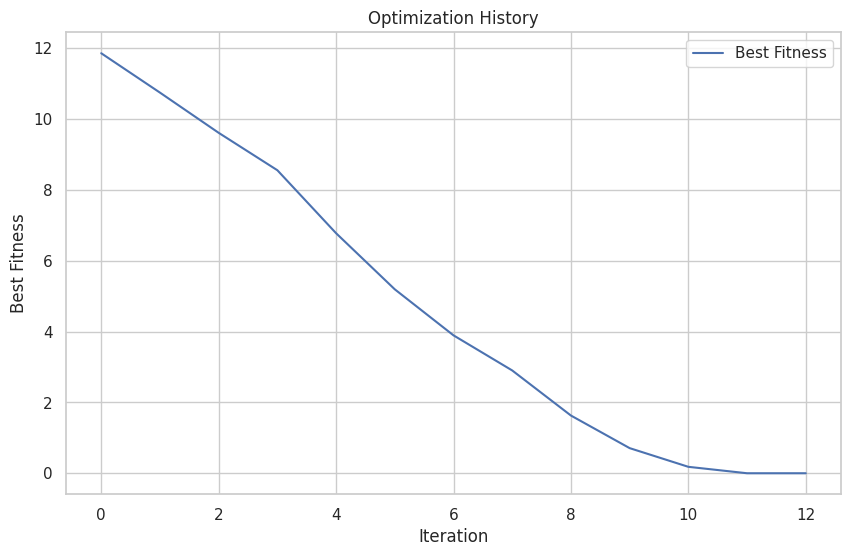

In [6]:
gsa.plot_optimization_history()